In [1]:
from rl.environments import Environment

from random import random

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
generation_cycles = 100
patient_count = 100
dose_history = 9
INR_history = 9
file_name = './sampled_policies.pkl'
RL_filename = 'WARF_00_00_XX_d_90_dose_9_INR_9_T_DQN_(20,20)_g_0.95_e_func_lr_0.01_buff_900_clr_F_btch_50_vld_0.3'

In [3]:
env = Environment(filename=RL_filename)
agent = env._agent['protocol']
subject = env._subject['W']

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Create state-action Dataset 

In [259]:
for i in range(generation_cycles):
    print('\n\ncycle {:03}\n'.format(i))
    print('Generating new records.')
    new_records = pd.concat([env.trajectory()['protocol'][['state', 'action']] for i in range(patient_count)], ignore_index=True)

    print('Reading previous records.')
    try:
        prev_records = pd.read_pickle(file_name)
        print('Combining all the records.')
        temp_df = pd.concat([prev_records, new_records], ignore_index=True)
    except FileNotFoundError:
        print('No previous records found.')
        temp_df = new_records

    print('Saving.')
    temp_df.to_pickle(file_name)



cycle 000

Generating new records.
Reading previous records.
Combining all the records.
Saving.


cycle 001

Generating new records.


KeyboardInterrupt: 

## Read the dataset and extract

In [4]:
temp_df = pd.read_pickle(file_name)

In [287]:
print('Extracting Xs and Ys.')
X = temp_df[:10000].apply(lambda row: [z for y in [x if hasattr(x, '__iter__') and not isinstance(x, str) else [x] for x in row.state.normalize().value] for z in y ] + row.action.as_list(), axis=1, result_type='expand')
Y = temp_df[:10000].apply(lambda row: row.action.as_list()[0], axis=1)

X.columns = ['age', '*1/*1', '*1/*2', '*1/*3', '*2/*2', '*2/*3', '*3/*3', 'G/G', 'G/A', 'A/A'] + ['dose-{:01}'.format(dose_history-i) for i in range(dose_history)] + ['INR-{:01}'.format(INR_history-i) for i in range(INR_history)] + ['INR_current', 'action']
Y.columns = ['action']

Extracting Xs and Ys.


## Clustering and its plot

In [288]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [306]:
X_embedded = TSNE(n_components=3).fit_transform(X)

In [310]:
plt.savefig('t-sne of kNN 5 of states - 10000.png')

<IPython.core.display.Javascript object>


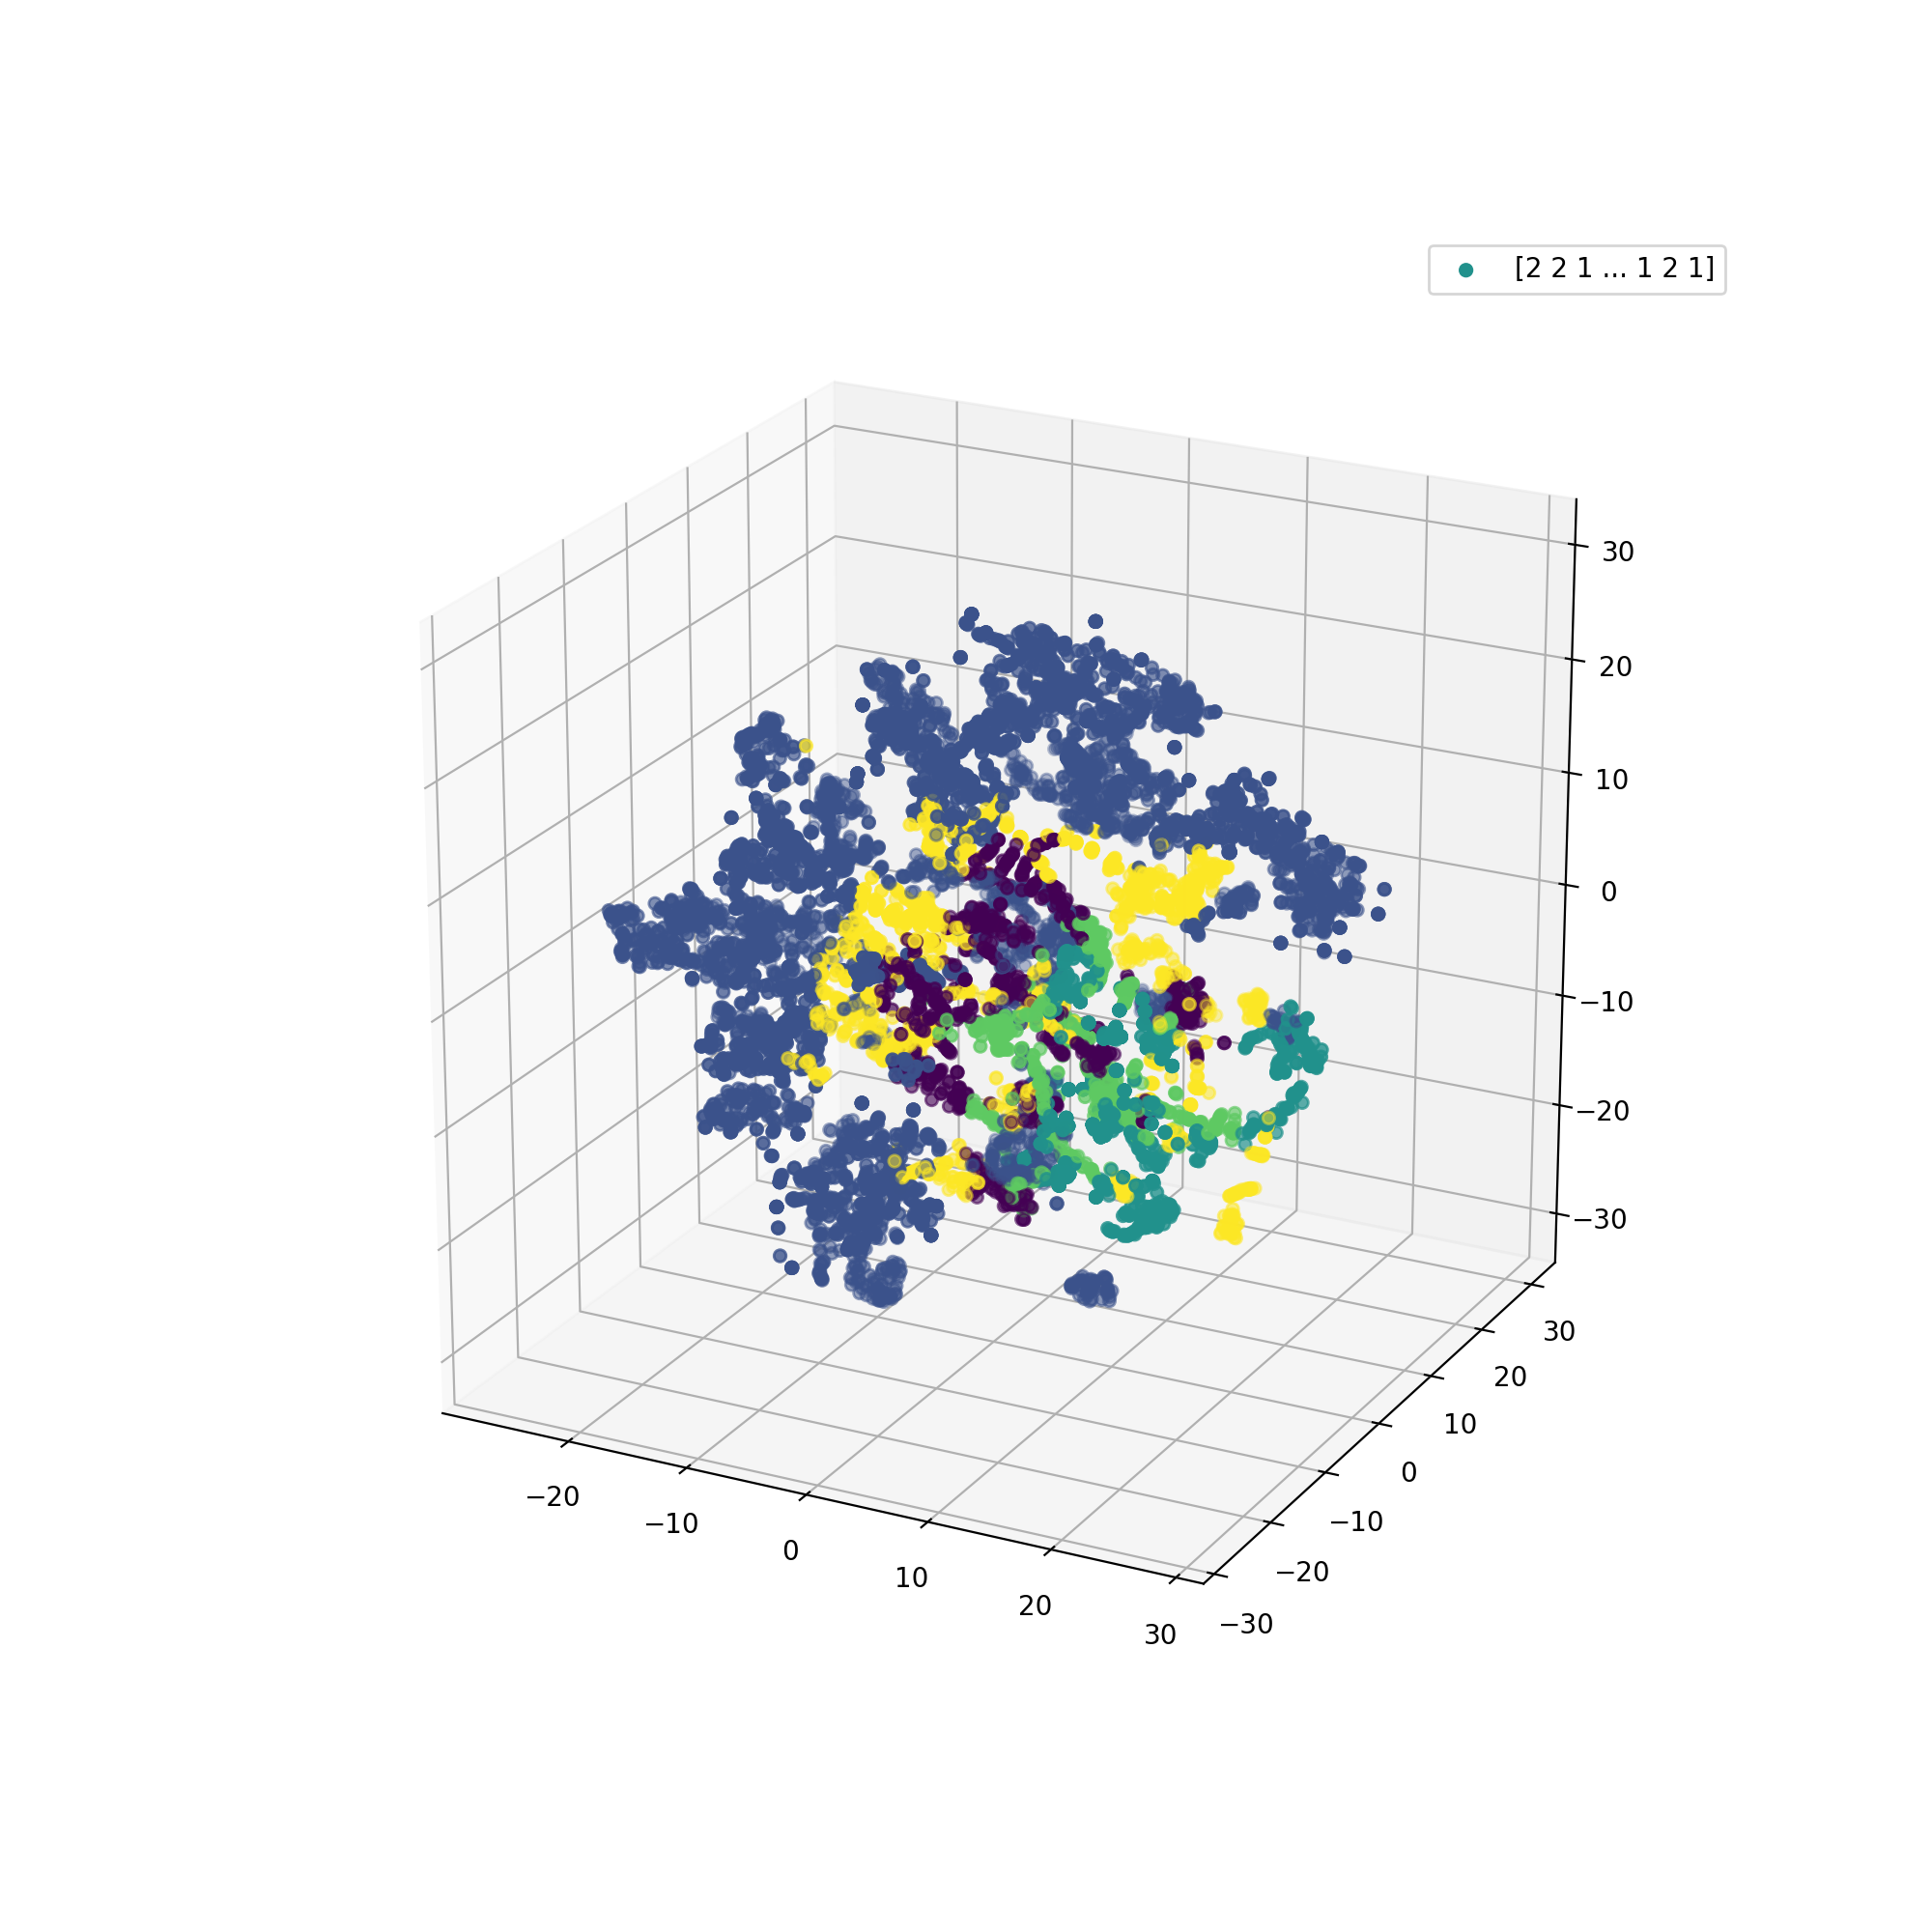

In [309]:
%matplotlib notebook

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')  # Axes3D(fig)
colors = dict((i, (random(), random(), random(), 0.7)) for i in pd.unique(Y))
scatter = ax.scatter(X_embedded[:, 0],
                     X_embedded[:, 1],
                     X_embedded[:, 2],
                     c=y_kmeans,
                     label=y_kmeans)
ax.legend()
plt.show()
#plt.savefig('t-sne of states - 10000.png')

## Plots per dose level

<IPython.core.display.Javascript object>


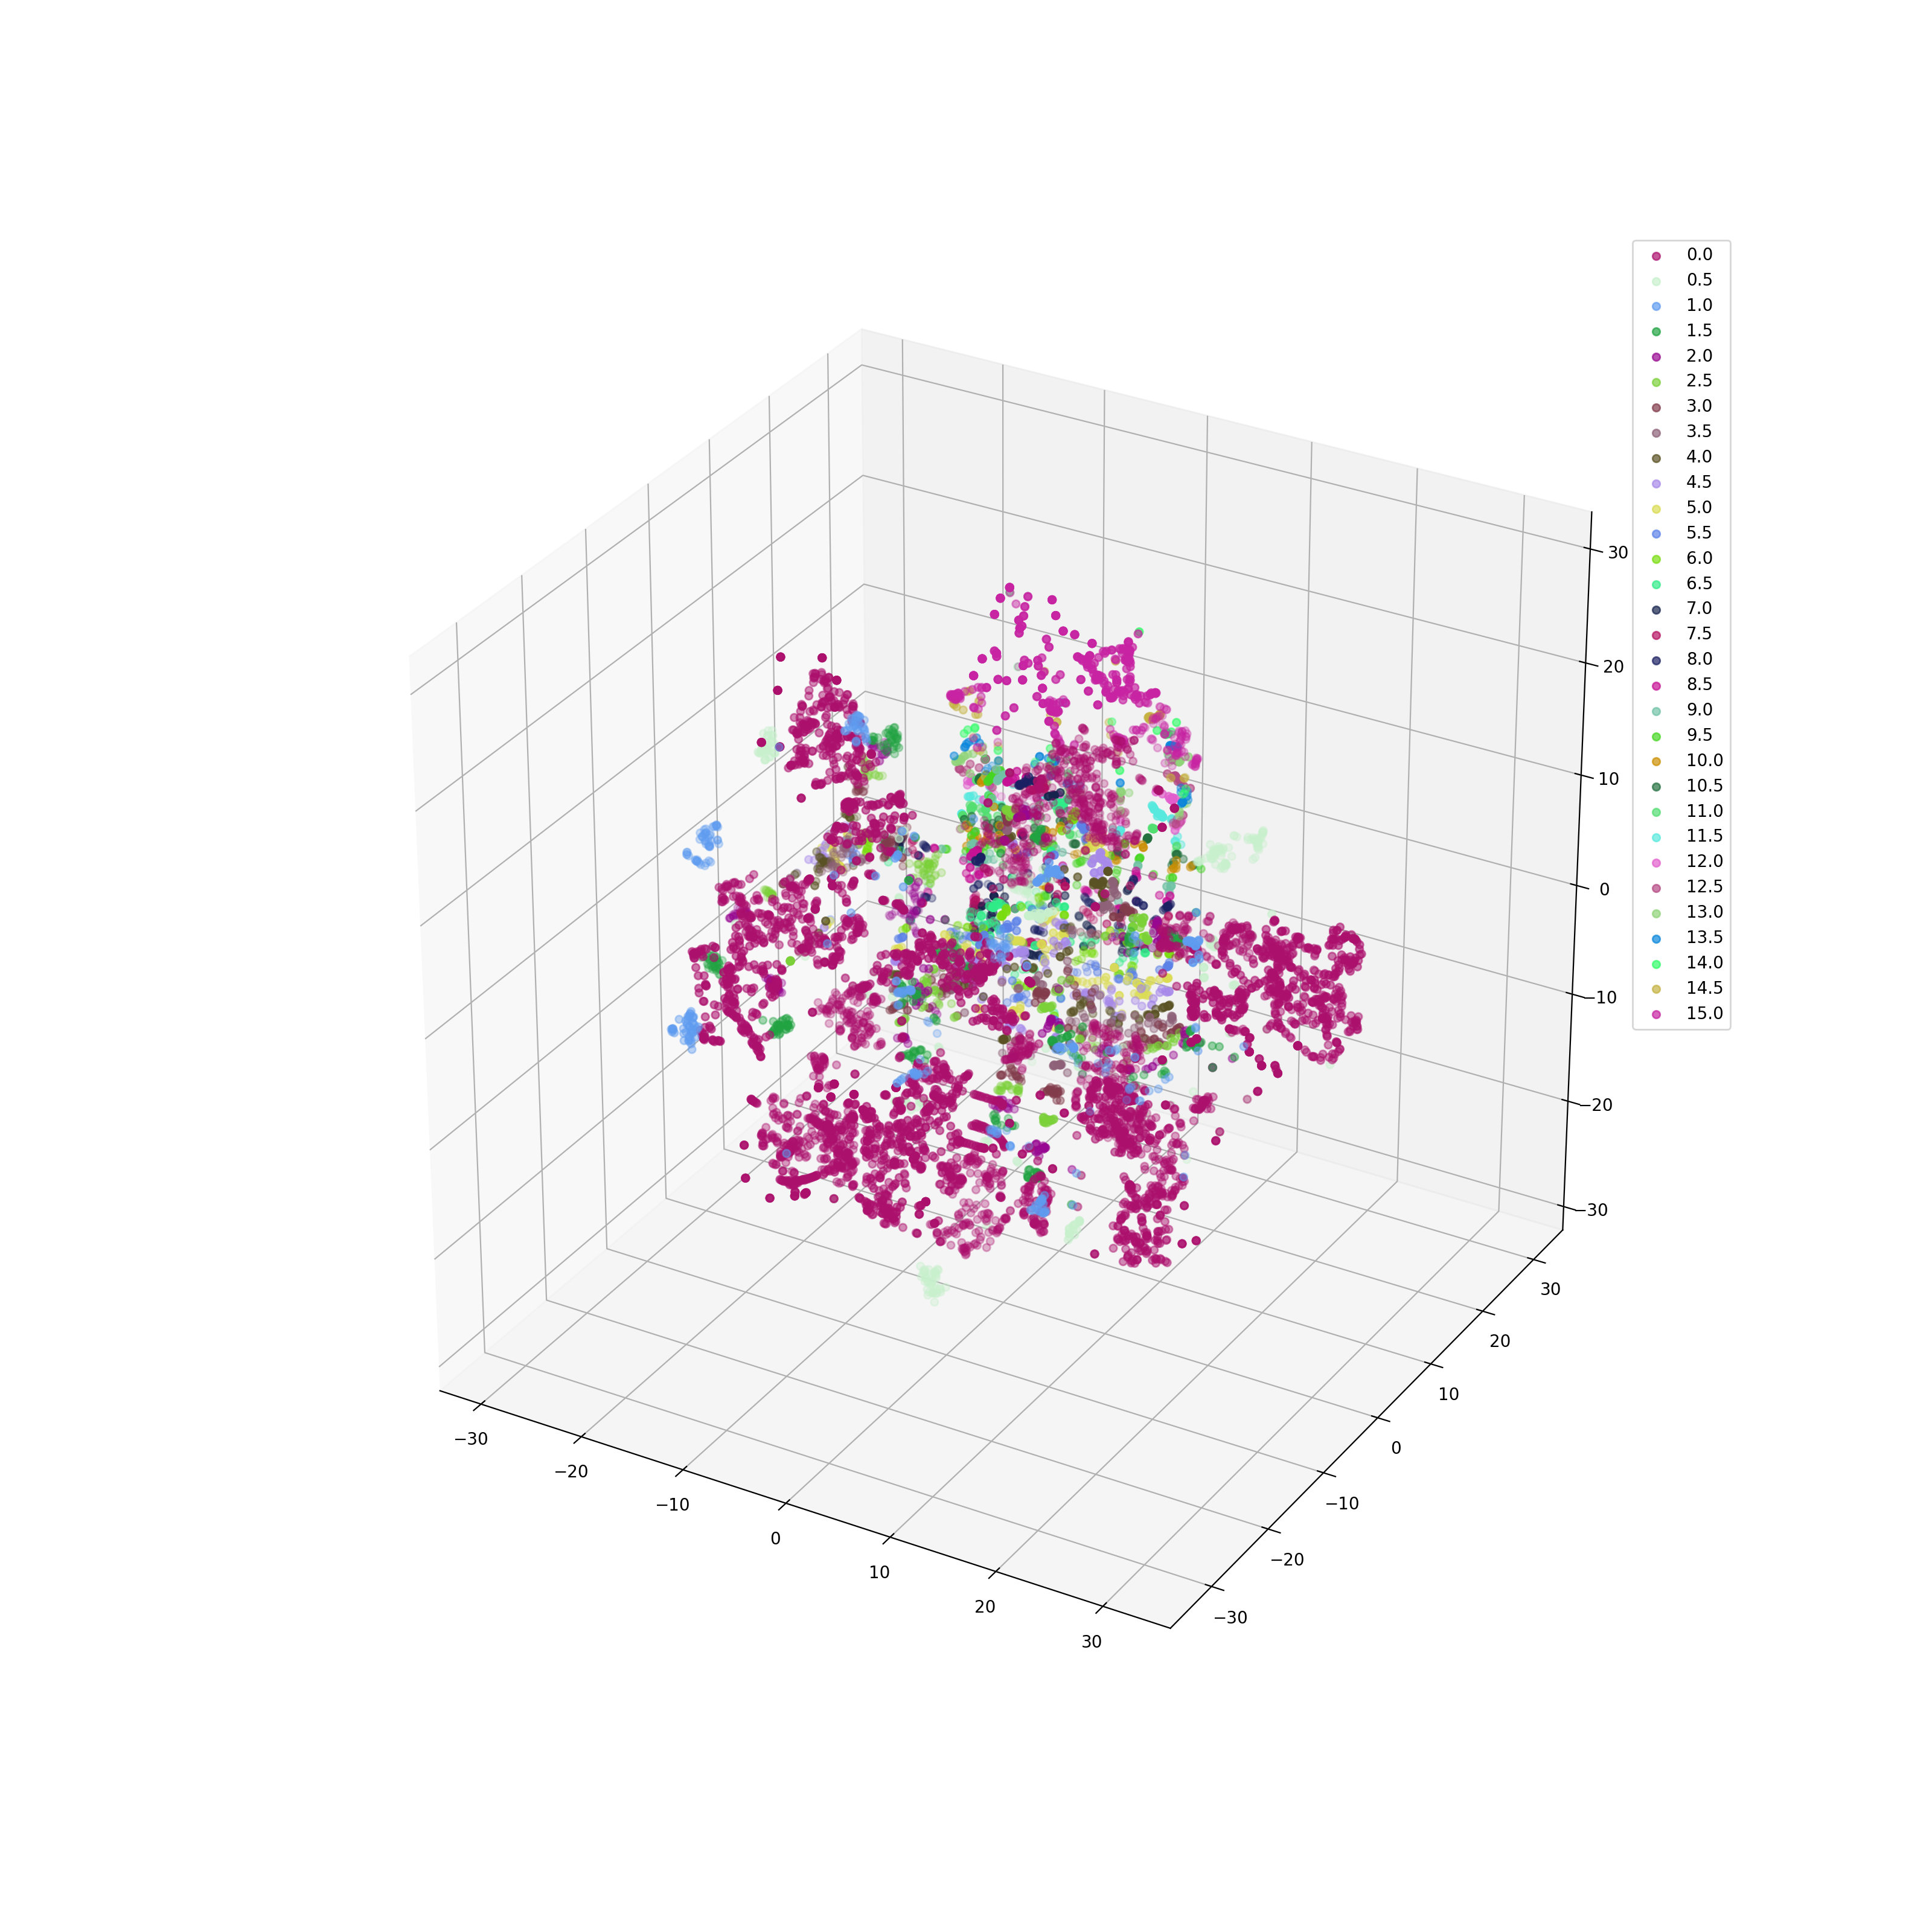

In [282]:
%matplotlib notebook

fig = plt.figure(figsize=(16, 16))
ax = fig.gca(projection='3d')  # Axes3D(fig)
colors = dict((i, (random(), random(), random(), 0.7)) for i in pd.unique(Y))
for label in sorted(pd.unique(Y)):
    scatter = ax.scatter(X_embedded[Y[Y==label].index, 0],
                         X_embedded[Y[Y==label].index, 1],
                         X_embedded[Y[Y==label].index, 2],
                         c=[colors[label]],
                         label=label)
ax.legend()
plt.show()
plt.savefig('t-sne of states - 10000.png')
    #plt.savefig('t-sne 3d of states - 10000 - {:02.1f}.png'.format(label))
    #plt.cla()

In [249]:
plt.savefig('t-sne of states.png')

## TTR

In [67]:
TTRs = {}
counts = {}
temp = temp_df
for i in range(0, temp_df.shape[0], 90):
    print('{:02}\tpatient: Age: {}, CYP2C9: {}, VKORC1: {}'.format(
      i,
      temp.state[i].value['Age'],
      temp.state[i].value['CYP2C9'],
      temp.state[i].value['VKORC1'])
     )

    try:
        TTR = sum(1 if 2.0<=temp.state[i+j].value.INRs[-1]<=3.0 else 0 for j in range(90)) / 90
        TTRs[(temp.state[i].value['Age'],
                 temp.state[i].value['CYP2C9'],
                 temp.state[i].value['VKORC1'])].append(TTR)

    except KeyError:
        TTRs[(temp.state[i].value['Age'],
                 temp.state[i].value['CYP2C9'],
                 temp.state[i].value['VKORC1'])] = [TTR]

print('TTR\npatient\t\t\tcount\tmin\taverage\tmax')
for patient, r in TTRs.items():
    print('{}\t{:3}\t{:2.2%}\t{:2.2%}\t{:2.2%}'.format(patient, len(r), min(r), sum(r)/len(r), max(r)))

00	patient: Age: 72, CYP2C9: *3/*3, VKORC1: G/A
90	patient: Age: 70, CYP2C9: *2/*3, VKORC1: G/G
180	patient: Age: 80, CYP2C9: *2/*3, VKORC1: G/G
270	patient: Age: 71, CYP2C9: *1/*1, VKORC1: G/G
360	patient: Age: 76, CYP2C9: *2/*2, VKORC1: G/A
450	patient: Age: 84, CYP2C9: *2/*2, VKORC1: G/A
540	patient: Age: 73, CYP2C9: *2/*3, VKORC1: G/A
630	patient: Age: 70, CYP2C9: *3/*3, VKORC1: A/A
720	patient: Age: 72, CYP2C9: *2/*2, VKORC1: G/A
810	patient: Age: 75, CYP2C9: *1/*2, VKORC1: G/A
900	patient: Age: 75, CYP2C9: *2/*2, VKORC1: G/A
990	patient: Age: 78, CYP2C9: *2/*2, VKORC1: G/A
1080	patient: Age: 74, CYP2C9: *2/*3, VKORC1: G/G
1170	patient: Age: 75, CYP2C9: *1/*1, VKORC1: G/A
1260	patient: Age: 74, CYP2C9: *1/*3, VKORC1: G/G
1350	patient: Age: 71, CYP2C9: *2/*3, VKORC1: A/A
1440	patient: Age: 74, CYP2C9: *1/*3, VKORC1: G/G
1530	patient: Age: 77, CYP2C9: *3/*3, VKORC1: G/A
1620	patient: Age: 74, CYP2C9: *2/*3, VKORC1: G/G
1710	patient: Age: 70, CYP2C9: *1/*2, VKORC1: A/A
1800	patient: 

20250	patient: Age: 85, CYP2C9: *1/*3, VKORC1: G/G
20340	patient: Age: 79, CYP2C9: *1/*2, VKORC1: G/A
20430	patient: Age: 82, CYP2C9: *1/*2, VKORC1: G/G
20520	patient: Age: 84, CYP2C9: *3/*3, VKORC1: A/A
20610	patient: Age: 72, CYP2C9: *2/*3, VKORC1: A/A
20700	patient: Age: 74, CYP2C9: *2/*2, VKORC1: A/A
20790	patient: Age: 70, CYP2C9: *1/*3, VKORC1: G/A
20880	patient: Age: 72, CYP2C9: *2/*2, VKORC1: G/A
20970	patient: Age: 79, CYP2C9: *1/*1, VKORC1: G/A
21060	patient: Age: 73, CYP2C9: *1/*3, VKORC1: A/A
21150	patient: Age: 80, CYP2C9: *2/*2, VKORC1: A/A
21240	patient: Age: 84, CYP2C9: *2/*3, VKORC1: G/A
21330	patient: Age: 81, CYP2C9: *2/*2, VKORC1: G/G
21420	patient: Age: 74, CYP2C9: *1/*3, VKORC1: G/G
21510	patient: Age: 72, CYP2C9: *2/*3, VKORC1: G/G
21600	patient: Age: 81, CYP2C9: *2/*3, VKORC1: G/G
21690	patient: Age: 75, CYP2C9: *3/*3, VKORC1: G/A
21780	patient: Age: 74, CYP2C9: *2/*2, VKORC1: G/G
21870	patient: Age: 72, CYP2C9: *2/*2, VKORC1: G/A
21960	patient: Age: 71, CYP2C9:

34740	patient: Age: 85, CYP2C9: *2/*2, VKORC1: G/G
34830	patient: Age: 83, CYP2C9: *1/*1, VKORC1: G/G
34920	patient: Age: 77, CYP2C9: *1/*1, VKORC1: G/G
35010	patient: Age: 84, CYP2C9: *2/*3, VKORC1: G/G
35100	patient: Age: 73, CYP2C9: *2/*3, VKORC1: A/A
35190	patient: Age: 71, CYP2C9: *1/*1, VKORC1: A/A
35280	patient: Age: 73, CYP2C9: *1/*1, VKORC1: G/A
35370	patient: Age: 76, CYP2C9: *1/*3, VKORC1: G/G
35460	patient: Age: 70, CYP2C9: *2/*3, VKORC1: G/G
35550	patient: Age: 81, CYP2C9: *2/*3, VKORC1: G/A
35640	patient: Age: 75, CYP2C9: *1/*2, VKORC1: G/G
35730	patient: Age: 71, CYP2C9: *1/*1, VKORC1: G/G
35820	patient: Age: 71, CYP2C9: *1/*1, VKORC1: A/A
35910	patient: Age: 80, CYP2C9: *2/*3, VKORC1: G/G
36000	patient: Age: 78, CYP2C9: *1/*2, VKORC1: A/A
36090	patient: Age: 84, CYP2C9: *2/*2, VKORC1: A/A
36180	patient: Age: 82, CYP2C9: *1/*3, VKORC1: G/G
36270	patient: Age: 78, CYP2C9: *1/*2, VKORC1: A/A
36360	patient: Age: 85, CYP2C9: *3/*3, VKORC1: G/G
36450	patient: Age: 72, CYP2C9:

51660	patient: Age: 82, CYP2C9: *1/*1, VKORC1: G/G
51750	patient: Age: 82, CYP2C9: *3/*3, VKORC1: G/G
51840	patient: Age: 84, CYP2C9: *3/*3, VKORC1: A/A
51930	patient: Age: 79, CYP2C9: *1/*3, VKORC1: G/A
52020	patient: Age: 80, CYP2C9: *1/*2, VKORC1: G/A
52110	patient: Age: 84, CYP2C9: *2/*2, VKORC1: G/G
52200	patient: Age: 78, CYP2C9: *3/*3, VKORC1: G/A
52290	patient: Age: 71, CYP2C9: *2/*3, VKORC1: G/A
52380	patient: Age: 73, CYP2C9: *3/*3, VKORC1: G/G
52470	patient: Age: 85, CYP2C9: *2/*2, VKORC1: G/A
52560	patient: Age: 80, CYP2C9: *1/*2, VKORC1: G/G
52650	patient: Age: 73, CYP2C9: *1/*3, VKORC1: A/A
52740	patient: Age: 73, CYP2C9: *3/*3, VKORC1: G/G
52830	patient: Age: 74, CYP2C9: *1/*2, VKORC1: G/G
52920	patient: Age: 77, CYP2C9: *1/*3, VKORC1: A/A
53010	patient: Age: 70, CYP2C9: *2/*3, VKORC1: A/A
53100	patient: Age: 75, CYP2C9: *3/*3, VKORC1: G/G
53190	patient: Age: 76, CYP2C9: *2/*2, VKORC1: G/A
53280	patient: Age: 71, CYP2C9: *2/*3, VKORC1: G/A
53370	patient: Age: 74, CYP2C9:

71010	patient: Age: 78, CYP2C9: *1/*2, VKORC1: A/A
71100	patient: Age: 77, CYP2C9: *2/*3, VKORC1: A/A
71190	patient: Age: 79, CYP2C9: *3/*3, VKORC1: G/A
71280	patient: Age: 72, CYP2C9: *1/*3, VKORC1: A/A
71370	patient: Age: 81, CYP2C9: *2/*2, VKORC1: G/G
71460	patient: Age: 79, CYP2C9: *1/*2, VKORC1: G/G
71550	patient: Age: 77, CYP2C9: *3/*3, VKORC1: G/A
71640	patient: Age: 73, CYP2C9: *1/*2, VKORC1: G/A
71730	patient: Age: 70, CYP2C9: *1/*1, VKORC1: G/A
71820	patient: Age: 71, CYP2C9: *1/*3, VKORC1: G/G
71910	patient: Age: 80, CYP2C9: *2/*2, VKORC1: G/G
72000	patient: Age: 82, CYP2C9: *1/*3, VKORC1: A/A
72090	patient: Age: 82, CYP2C9: *1/*1, VKORC1: G/A
72180	patient: Age: 76, CYP2C9: *2/*3, VKORC1: G/G
72270	patient: Age: 76, CYP2C9: *2/*3, VKORC1: G/G
72360	patient: Age: 80, CYP2C9: *1/*1, VKORC1: G/A
72450	patient: Age: 72, CYP2C9: *1/*3, VKORC1: A/A
72540	patient: Age: 74, CYP2C9: *1/*3, VKORC1: A/A
72630	patient: Age: 74, CYP2C9: *1/*3, VKORC1: G/G
72720	patient: Age: 72, CYP2C9:

88650	patient: Age: 80, CYP2C9: *2/*3, VKORC1: G/G
88740	patient: Age: 84, CYP2C9: *3/*3, VKORC1: G/G
88830	patient: Age: 73, CYP2C9: *3/*3, VKORC1: A/A
88920	patient: Age: 77, CYP2C9: *1/*2, VKORC1: G/G
89010	patient: Age: 81, CYP2C9: *1/*1, VKORC1: G/A
89100	patient: Age: 80, CYP2C9: *2/*3, VKORC1: A/A
89190	patient: Age: 83, CYP2C9: *1/*2, VKORC1: A/A
89280	patient: Age: 78, CYP2C9: *2/*3, VKORC1: A/A
89370	patient: Age: 83, CYP2C9: *1/*3, VKORC1: G/G
89460	patient: Age: 82, CYP2C9: *3/*3, VKORC1: G/G
89550	patient: Age: 79, CYP2C9: *1/*1, VKORC1: G/G
89640	patient: Age: 75, CYP2C9: *3/*3, VKORC1: A/A
89730	patient: Age: 79, CYP2C9: *2/*2, VKORC1: G/A
89820	patient: Age: 83, CYP2C9: *1/*3, VKORC1: G/G
89910	patient: Age: 75, CYP2C9: *1/*3, VKORC1: G/A
90000	patient: Age: 82, CYP2C9: *1/*2, VKORC1: A/A
90090	patient: Age: 84, CYP2C9: *1/*1, VKORC1: A/A
90180	patient: Age: 79, CYP2C9: *3/*3, VKORC1: A/A
90270	patient: Age: 83, CYP2C9: *1/*2, VKORC1: A/A
90360	patient: Age: 82, CYP2C9:

104580	patient: Age: 79, CYP2C9: *2/*2, VKORC1: A/A
104670	patient: Age: 79, CYP2C9: *2/*3, VKORC1: G/G
104760	patient: Age: 85, CYP2C9: *2/*3, VKORC1: G/G
104850	patient: Age: 70, CYP2C9: *1/*2, VKORC1: A/A
104940	patient: Age: 74, CYP2C9: *2/*2, VKORC1: A/A
105030	patient: Age: 85, CYP2C9: *2/*2, VKORC1: G/A
105120	patient: Age: 75, CYP2C9: *3/*3, VKORC1: G/G
105210	patient: Age: 83, CYP2C9: *1/*1, VKORC1: A/A
105300	patient: Age: 70, CYP2C9: *2/*3, VKORC1: G/A
105390	patient: Age: 80, CYP2C9: *3/*3, VKORC1: G/G
105480	patient: Age: 82, CYP2C9: *2/*2, VKORC1: G/A
105570	patient: Age: 75, CYP2C9: *2/*3, VKORC1: G/G
105660	patient: Age: 72, CYP2C9: *2/*3, VKORC1: G/A
105750	patient: Age: 72, CYP2C9: *1/*1, VKORC1: G/A
105840	patient: Age: 70, CYP2C9: *2/*2, VKORC1: G/A
105930	patient: Age: 83, CYP2C9: *2/*3, VKORC1: G/G
106020	patient: Age: 84, CYP2C9: *1/*2, VKORC1: G/A
106110	patient: Age: 81, CYP2C9: *2/*2, VKORC1: A/A
106200	patient: Age: 77, CYP2C9: *1/*3, VKORC1: A/A
106290	patie

120600	patient: Age: 82, CYP2C9: *1/*1, VKORC1: G/A
120690	patient: Age: 76, CYP2C9: *1/*2, VKORC1: A/A
120780	patient: Age: 75, CYP2C9: *1/*1, VKORC1: A/A
120870	patient: Age: 83, CYP2C9: *2/*2, VKORC1: G/A
120960	patient: Age: 73, CYP2C9: *2/*3, VKORC1: A/A
121050	patient: Age: 76, CYP2C9: *2/*2, VKORC1: G/G
121140	patient: Age: 85, CYP2C9: *2/*3, VKORC1: G/G
121230	patient: Age: 70, CYP2C9: *1/*3, VKORC1: G/G
121320	patient: Age: 72, CYP2C9: *2/*3, VKORC1: G/A
121410	patient: Age: 82, CYP2C9: *1/*1, VKORC1: G/A
121500	patient: Age: 80, CYP2C9: *1/*3, VKORC1: A/A
121590	patient: Age: 83, CYP2C9: *2/*2, VKORC1: A/A
121680	patient: Age: 80, CYP2C9: *1/*2, VKORC1: G/A
121770	patient: Age: 85, CYP2C9: *1/*1, VKORC1: G/A
121860	patient: Age: 82, CYP2C9: *1/*2, VKORC1: G/G
121950	patient: Age: 75, CYP2C9: *1/*3, VKORC1: G/A
122040	patient: Age: 83, CYP2C9: *1/*1, VKORC1: A/A
122130	patient: Age: 70, CYP2C9: *2/*3, VKORC1: A/A
122220	patient: Age: 75, CYP2C9: *2/*2, VKORC1: A/A
122310	patie

In [56]:
TTRs = {}
counts = {}
temp = temp_df
for i in range(temp_df.shape[0]):
#    print('{:02}\tpatient: Age: {}, CYP2C9: {}, VKORC1: {}'.format(
 #     i,
  #    temp.state[i].value['Age'],
   #   temp.state[i].value['CYP2C9'],
    #  temp.state[i].value['VKORC1'])
     #)
    try:
        TTRs[(temp.state[i].value['Age'],
                 temp.state[i].value['CYP2C9'],
                 temp.state[i].value['VKORC1'])] += 1 if 2.0 <= temp_df.state[i].value.INRs[-1] <= 3.0 else 0
        counts[(temp.state[i].value['Age'],
                 temp.state[i].value['CYP2C9'],
                 temp.state[i].value['VKORC1'])] += 1
    except KeyError:
        TTRs[(temp.state[i].value['Age'],
                 temp.state[i].value['CYP2C9'],
                 temp.state[i].value['VKORC1'])] = 1 if 2.0 <= temp_df.state[i].value.INRs[-1] <= 3.0 else 0
        counts[(temp.state[i].value['Age'],
                 temp.state[i].value['CYP2C9'],
                 temp.state[i].value['VKORC1'])] = 1

print('TTR\npatient\t\t\tcount\tTTR')
for patient, r in TTRs.items():
    print('{}\t{:3}\t{:3.2%}'.format(patient, counts[patient], r/counts[patient]))  # len(r), min(r), sum(r)/len(r), max(r)))

TTR
patient			TTR
(72, '*3/*3', 'G/A')	95.28%
(70, '*2/*3', 'G/G')	92.96%
(80, '*2/*3', 'G/G')	94.29%
(71, '*1/*1', 'G/G')	54.72%
(76, '*2/*2', 'G/A')	90.56%
(84, '*2/*2', 'G/A')	96.44%
(73, '*2/*3', 'G/A')	85.78%
(70, '*3/*3', 'A/A')	47.96%
(72, '*2/*2', 'G/A')	83.02%
(75, '*1/*2', 'G/A')	87.78%
(75, '*2/*2', 'G/A')	90.56%
(78, '*2/*2', 'G/A')	93.61%
(74, '*2/*3', 'G/G')	93.65%
(75, '*1/*1', 'G/A')	65.74%
(74, '*1/*3', 'G/G')	80.49%
(71, '*2/*3', 'A/A')	88.89%
(77, '*3/*3', 'G/A')	94.17%
(70, '*1/*2', 'A/A')	85.28%
(82, '*1/*3', 'A/A')	84.00%
(76, '*1/*1', 'G/A')	67.04%
(76, '*2/*2', 'G/G')	88.56%
(73, '*2/*2', 'G/A')	96.94%
(79, '*2/*2', 'A/A')	94.89%
(79, '*3/*3', 'A/A')	77.11%
(84, '*3/*3', 'A/A')	81.30%
(84, '*1/*2', 'G/G')	70.56%
(70, '*1/*2', 'G/G')	74.44%
(74, '*1/*1', 'G/A')	69.09%
(78, '*1/*1', 'G/A')	80.44%
(73, '*3/*3', 'A/A')	53.02%
(74, '*1/*2', 'G/G')	77.78%
(78, '*1/*1', 'A/A')	69.17%
(83, '*1/*3', 'G/A')	85.78%
(70, '*1/*3', 'G/A')	89.05%
(72, '*1/*2', 'A/A')	84.81%
(8

In [58]:
print('TTR\npatient\t\t\tcount\tTTR')
for patient, r in TTRs.items():
    print('{}\t{:3}\t{:3.2%}'.format(patient, counts[patient]/90, r/counts[patient]))

TTR
patient			count	TTR
(72, '*3/*3', 'G/A')	4.0	95.28%
(70, '*2/*3', 'G/G')	6.0	92.96%
(80, '*2/*3', 'G/G')	7.0	94.29%
(71, '*1/*1', 'G/G')	8.0	54.72%
(76, '*2/*2', 'G/A')	10.0	90.56%
(84, '*2/*2', 'G/A')	5.0	96.44%
(73, '*2/*3', 'G/A')	5.0	85.78%
(70, '*3/*3', 'A/A')	6.0	47.96%
(72, '*2/*2', 'G/A')	7.0	83.02%
(75, '*1/*2', 'G/A')	5.0	87.78%
(75, '*2/*2', 'G/A')	4.0	90.56%
(78, '*2/*2', 'G/A')	4.0	93.61%
(74, '*2/*3', 'G/G')	7.0	93.65%
(75, '*1/*1', 'G/A')	6.0	65.74%
(74, '*1/*3', 'G/G')	9.0	80.49%
(71, '*2/*3', 'A/A')	2.0	88.89%
(77, '*3/*3', 'G/A')	8.0	94.17%
(70, '*1/*2', 'A/A')	4.0	85.28%
(82, '*1/*3', 'A/A')	5.0	84.00%
(76, '*1/*1', 'G/A')	3.0	67.04%
(76, '*2/*2', 'G/G')	10.0	88.56%
(73, '*2/*2', 'G/A')	4.0	96.94%
(79, '*2/*2', 'A/A')	5.0	94.89%
(79, '*3/*3', 'A/A')	5.0	77.11%
(84, '*3/*3', 'A/A')	6.0	81.30%
(84, '*1/*2', 'G/G')	10.0	70.56%
(70, '*1/*2', 'G/G')	4.0	74.44%
(74, '*1/*1', 'G/A')	11.0	69.09%
(78, '*1/*1', 'G/A')	10.0	80.44%
(73, '*3/*3', 'A/A')	7.0	53.02%
(74, '*1/*2

## One Patient

In [ ]:
temp = env.trajectory()['protocol']
print('patient: Age: {}, CYP2C9: {}, VKORC1: {}'.format(
      temp.state[0].value['Age'],
      temp.state[0].value['CYP2C9'],
      temp.state[0].value['VKORC1'])
     )
print('day\tINR\taction\treward')
TTR = 0
for t in temp.iterrows():
    print('{}\t{:3.1f}\t{:5.1f}\t{:3.2f}'.format(t[0],
                                              t[1].state.value['INRs'][-1],
                                              t[1].action.value['value'],
                                              t[1].reward))
    if 2 <= t[1].state.value['INRs'][-1] <= 3:
        TTR += 1
print(TTR/90)

In [ ]:
TTRs = {}
actions = {}
for i in range(50):
    
    temp = env.trajectory()['protocol']
    print('{:02}\tpatient: Age: {}, CYP2C9: {}, VKORC1: {}'.format(
      i,
      temp.state[0].value['Age'],
      temp.state[0].value['CYP2C9'],
      temp.state[0].value['VKORC1'])
     )
    try:
        TTR = sum(1 if 2.0<=t[1].state.value['INRs'][-1]<=3.0 else 0 for t in temp.iterrows()) / len(temp)
        ave_action = sum(t[1].action.value['value'] for t in temp.iterrows()) / len(temp)
        TTRs[(temp.state[0].value['Age'],
                 temp.state[0].value['CYP2C9'],
                 temp.state[0].value['VKORC1'])].append(TTR)
        actions[(temp.state[0].value['Age'],
                temp.state[0].value['CYP2C9'],
                temp.state[0].value['VKORC1'])].append(ave_action)
    except KeyError:
        TTRs[(temp.state[0].value['Age'],
                 temp.state[0].value['CYP2C9'],
                 temp.state[0].value['VKORC1'])] = [TTR]
        actions[(temp.state[0].value['Age'],
                 temp.state[0].value['CYP2C9'],
                 temp.state[0].value['VKORC1'])] = [ave_action]

print('TTR\npatient\t\t\tcount\tmin\taverage\tmax')
for patient, r in TTRs.items():
    print('{}\t{:3}\t{:2.2%}\t{:2.2%}\t{:2.2%}'.format(patient, len(r), min(r), sum(r)/len(r), max(r)))

print('actions\npatient\t\t\tcount\tmin\taverage\tmax')
for patient, r in actions.items():
    print('{}\t{:3}\t{:3.2}\t{:3.2}\t{:3.2}'.format(patient, len(r), min(r), sum(r)/len(r), max(r)))

In [ ]:
import json

j_results = {}
for p, v in results.items():
    j_results[', '.join((p[2], p[1], str(p[0])))] = v

with open("10000patients.json", "w") as write_file:
    json.dump(j_results, write_file)
    

In [ ]:
all_records = []
for p, value in results.items():
    all_records.extend(list((p, v) for v in value))
    
for r in all_records:
    print(r[0], r[1])

In [ ]:
import csv
csv.writer()

In [ ]:
for patient in sorted(results, key=lambda s: s[2]+s[1]+str(s[0])):
    print('\t'.join((patient[2], patient[1], str(patient[0]),
                     '{: 3}'.format(len(results[patient])),
                     '{:3.2}'.format(min(results[patient])),
                     '{:3.2}'.format(sum(results[patient])/len(results[patient])),
                     '{:3.2}'.format(max(results[patient])))))